In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

#from bandits_improved import *
#from client_improved import *
#from server_improved import *

In [ ]:
#client 
import numpy as np

class client(object):
    def __init__(self,
                 index,
                 thorizon,
                 narms,
                 nclients,
                 palpha,
                 fp):
        self.T = thorizon
        self.id = index
        self.K = narms
        self.M = nclients
        self.alpha = palpha
        self.fp = fp
        
        self.p = 1
        self.local_set = set(np.arange(self.K)) #set of arms for local exploration
        self.global_set = set(np.arange(self.K)) #set of arms for global exploration
        self.local_mean = np.zeros(self.K)
        self.global_mean = np.zeros(self.K)
        self.mixed_mean = np.zeros(self.K)
        self.reward = np.zeros(self.K)
        
        self.pull = np.zeros(self.K)
        self.p_length = self.fp(self.p)
        self.Fp = 0
        
        self.fphase = 0
        self.gphase = 0
        
        self.F = -1
        self.l_exploration = False
        self.g_exploration = False
    
    def play(self):
        if self.fphase < np.ceil((1-self.alpha)*self.p_length)*len(self.global_set): #global exploration
#            print("loc", self.p)
            #play = list(self.global_set)[self.fphase%len(self.global_set)]
            play = list(self.global_set)[int(self.fphase//(np.ceil((1-self.alpha)*self.p_length)))]
            self.fphase += 1
            
        elif self.gphase < np.ceil(self.M*self.alpha*self.p_length)*len(self.local_set): #local exploration
#            print("glob", self.p)
            #play = list(self.local_set)[self.gphase%len(self.local_set)]
            play = list(self.local_set)[int(self.gphase//(np.ceil(self.M*self.alpha*self.p_length)))]
            self.gphase += 1
            
        else: #exploitation phase
            if self.l_exploration is True:
                play = self.F
            else:
                play = np.argmax(self.alpha*self.local_mean+(1-self.alpha)*self.global_mean)
            
        return play
    
    def reward_update(self,play,obs):
        self.reward[play] += obs
        self.pull[play] += 1
        
    def local_mean_update(self):
        #print('global',self.fphase,np.ceil((1-self.alpha)*self.p_length)*len(self.global_set))
        #print('local',self.gphase,np.ceil(self.M*self.alpha*self.p_length)*len(self.local_set))
        if self.g_exploration is False and self.fphase >= np.ceil((1-self.alpha)*self.p_length)*len(self.global_set) and self.gphase >= np.ceil(self.M*self.alpha*self.p_length)*len(self.local_set):
            self.local_mean = self.reward/self.pull
            #print("local_mean",self.local_mean, "phase", self.p)
            return True, self.local_mean
        else:
            return False, 0
        
    def global_mean_update(self,global_stat):
        self.global_mean = global_stat
        self.mixed_mean = self.alpha*self.local_mean+(1-self.alpha)*self.global_mean
        
    def local_set_update(self):
        Ep = set()
        self.Fp += self.p_length
        conf_bound = np.sqrt(np.log(self.T)/(self.M*self.Fp))
        for i in list(self.local_set):
            if self.mixed_mean[i]+conf_bound < max(self.mixed_mean-conf_bound):
                Ep.add(i)
        self.local_set = self.local_set-Ep
        
        if len(self.local_set) == 1 and self.l_exploration is False:
            self.l_exploration = True
            self.F = list(self.local_set)[0]
            #print("player", self.id,  " fixate",self.F)
            self.local_set = set()
        #print("player", self.id, " local-set:",self.local_set)    
        return self.local_set
        
        
    def global_set_update(self,global_set):
        self.global_set = global_set
        self.p +=1
        self.p_length = self.fp(self.p)
        #print("p-length",self.p_length)
        self.fphase = 0
        self.gphase = 0
        self.g_exploration = (len(self.global_set)==0)
        
            
            
    
            

In [ ]:
#server

import numpy as np

class server(object):
    def __init__(self,
                 narms,
                 nclients):
        self.M = nclients
        self.K = narms
        
        self.local_means = np.zeros([self.M,self.K])
        self.global_means = np.zeros(self.K)
        self.global_set = set()
        self.p = 1
        self.c_local_stat = np.zeros(self.M)
        
    def local_mean_update(self,i,local_stat):
        self.local_means[i] = local_stat
        self.c_local_stat[i] = 1
        
    def global_mean_update(self):
        self.global_set = set()
        if sum(self.c_local_stat) >= self.M:
            self.global_means = np.sum(self.local_means, axis=0)/self.M
            self.c_local_stat = np.zeros(self.M)
            return True, self.global_means
        else:
            return False, 0
        
    def local_set_update(self,i,local_set):
        self.global_set = self.global_set|local_set
    
    def global_set_update(self):
        return self.global_set

In [ ]:
#bandits
class PFEDUCB(object):
    def __init__(self,
                 fun_fp,
                 T,
                 means, # M*K
                 alpha,
                 reward='Gaussian'):
        self.M = means.shape[0]
        self.K = means.shape[1]
        self.local_means = means
        self.reward_type = reward
        self.alpha = alpha
        self.T = T
        self.C = 1
        self.comm = 0
        
        self.global_means = np.sum(self.local_means, axis=0)/self.M
        self.clients = [
            client(index = i, thorizon = self.T, narms=self.K, nclients = self.M, palpha = self.alpha, fp=fun_fp) for i in range(self.M)
        ]
        self.server = server(narms=self.K, nclients = self.M)


    def simulate_single_step_rewards(self):
        if self.reward_type == 'Bernoulli':
            return np.random.binomial(1, self.local_means)
        return np.random.normal(self.local_means, 1)

    def simulate_single_step(self, plays):

        local_rews = self.simulate_single_step_rewards()
        global_rews = np.mean(local_rews,axis=0)
        
        local_rewards = np.array([local_rews[i,plays[i]] for i in range(self.M)])
        global_rewards = np.array([global_rews[plays[i]] for i in range(self.M)])
        mixed_rewards = self.alpha*local_rewards+(1-self.alpha)*global_rewards
        #rewards = np.array([self.alpha*local_rews[i,plays[i]]+(1-self.alpha)*global_rews[plays[i]] for i in range(self.M)])

        return local_rewards, global_rewards, mixed_rewards

    def simulate(self):
        """
        Return the vector of regret for each time step until horizon
        """

        local_rewards = []
        global_rewards = []
        mixed_rewards = []
        
        play_history = []
           

        for t in range(self.T):
            plays = np.zeros(self.M)
            
            plays = [(int)(client.play()) for client in self.clients]
            local_rews, global_rews, mixed_rews = self.simulate_single_step(plays)
            #obs, rews = self.simulate_single_step(plays)  # observations of all players
            
            local_rewards.append(np.sum(local_rews))
            global_rewards.append(np.sum(global_rews))
            mixed_rewards.append(np.sum(mixed_rews))
            play_history.append(plays)
            
            #print(plays)
            
            for i in range(self.M):
                self.clients[i].reward_update(plays[i], local_rews[i])  # update strategies of all player

            for i in range(self.M):
                f_local_stat, local_stat = self.clients[i].local_mean_update()
                if f_local_stat is True:
                    self.server.local_mean_update(i,local_stat)
                f_local_stat = False
                    
            f_global_stat, global_stat = self.server.global_mean_update()
            
            if f_global_stat is True:
                for i in range(self.M):
                    self.clients[i].global_mean_update(global_stat)
                    local_set = self.clients[i].local_set_update()
                    self.server.local_set_update(i,local_set)
                
                global_set = self.server.global_set_update()
                #print(t," global-set:",global_set)
                for i in range(self.M):
                    self.clients[i].global_set_update(global_set)
                    local_rewards[-1] -= 2*self.C
                    global_rewards[-1] -= 2*self.C
                    mixed_rewards[-1] -= 2*self.C
                    self.comm += 2*self.C
                    #print(t,"comm")
                f_global_stat = False
            
        top_mixed_means = np.zeros(self.M)
        
        top_arms = np.zeros(self.M, dtype=int)
        sub_gap = np.zeros(self.M)
        for i in range(self.M):
            top_arms[i] = np.argmax(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)
            top_mixed_means[i] = self.alpha*self.local_means[i][top_arms[i]]+(1-self.alpha)*self.global_means[top_arms[i]]
            sub_gap[i] = np.sort(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)[-2]-top_mixed_means[i]
            #print("player", i, " top_arm:",top_arms[i], " top_mean:", top_mixed_means[i], " gap:", sub_gap[i])
        
        best_case_reward = np.sum(top_mixed_means) * np.arange(1, self.T + 1)
        
        cumulated_local_reward = np.cumsum(local_rewards)
        cumulated_global_reward = np.cumsum(global_rewards)
        cumulated_mixed_reward = np.cumsum(mixed_rewards)

        regret = best_case_reward - cumulated_mixed_reward
#        print(cumulated_mixed_reward)
#        print(best_case_reward)
#        print('regret:',regret[-1], "comm: ", self.comm)
        self.regret = (regret, best_case_reward, cumulated_mixed_reward)
        self.top_mixed_means = top_mixed_means
        return regret, cumulated_local_reward, cumulated_global_reward, cumulated_mixed_reward

    def get_clients(self):
        return self.clients

In [ ]:
T = 1000000
K = 9
M = 4
alpha_list = np.array([0, 0.2, 0.5, 0.9, 1])
#means = np.random.random((M, K))


means = np.array([[1 , 0, 0, 0, 0.9, 0.4, 0.35, 0.35, 0.5],
                  [0, 1, 0, 0, 0.3, 0.9, 0.35, 0.3, 0.5],
                  [0, 0, 1, 0, 0.35, 0.35, 0.9, 0.3, 0.5],
                  [0, 0, 0, 1, 0.4, 0.3, 0.35, 0.9, 0.5]])

n_simu = 10

print(means)

[[1.   0.   0.   0.   0.9  0.4  0.35 0.35 0.5 ]
 [0.   1.   0.   0.   0.3  0.9  0.35 0.3  0.5 ]
 [0.   0.   1.   0.   0.35 0.35 0.9  0.3  0.5 ]
 [0.   0.   0.   1.   0.4  0.3  0.35 0.9  0.5 ]]


In [ ]:
def fp(p):
    return 2**p*np.log(T)

In [ ]:
try:
    regret_reward = np.load('scores/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
try:  
    raw_regret = np.load('scores/raw_regret.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}
    
try:  
    local_reward = np.load('scores/local_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}
    
try:  
    global_reward = np.load('scores/global_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}
    
try:  
    mixed_reward = np.load('scores/mixed_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [ ]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1

    # also saves the scores if we ran the whole algorithm without interrupting
    np.save('content/scores/raw_regret.npy', raw_regret)
    np.save('content/scores/local_reward.npy',local_reward)
    np.save('content/scores/global_reward.npy',global_reward)
    np.save('content/scores/mixed_reward.npy',mixed_reward)
    np.save('content/scores/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, mixed_reward, regret_reward

    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(round(alpha,2))]))
    np.save('scores/raw_regret.npy', raw_regret)
    np.save('scores/local_reward.npy',local_reward)
    np.save('scores/global_reward.npy',global_reward)
    np.save('scores/mixed_reward.npy',mixed_reward)
    np.save('scores/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward


Simulating P-Fed-UCB, alpha:1.0: 100%|██████████| 10/10 [19:58<00:00, 119.85s/it]


FileNotFoundError: ignored

In [ ]:
np.save('content/scores/raw_regret.npy', raw_regret)
np.save('content/scores/local_reward.npy',local_reward)
np.save('content/scores/global_reward.npy',global_reward)
np.save('content/scores/mixed_reward.npy',mixed_reward)
np.save('content/scores/regret_reward.npy', regret_reward)
#del raw_regret, local_reward, global_reward, mixed_reward, regret_reward

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


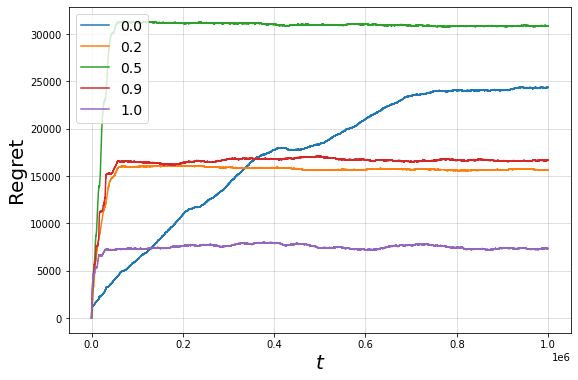

In [ ]:
try:
    regret_reward = np.load('content/scores/regret_reward.npy', allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)

#Improved

In [ ]:
import numpy as np

class imp_client(object):
    def __init__(self,
                 index,
                 thorizon,
                 narms,
                 nclients,
                 palpha,
                 fp):
        self.T = thorizon
        self.id = index
        self.K = narms
        self.M = nclients
        self.alpha = palpha
        self.fp = fp
        
        self.p = 1
        self.local_set = set(np.arange(self.K))
        self.global_set = set(np.arange(self.K))
        self.local_mean = np.zeros(self.K)
        self.global_mean = np.zeros(self.K)
        self.mixed_mean = np.zeros(self.K)
        
        self.local_delta = np.ones(self.K)
        self.global_delta = np.ones([self.M,self.K])
        
        self.reward = np.zeros(self.K)
        self.pull = np.zeros(self.K)
        self.p_length = self.fp(self.p)
        self.Fp = 0
        
        self.farm = 0
        self.farm_pull = np.zeros(self.K)
        self.garm = 0
        self.garm_pull = np.zeros(self.K)
        self.imp_factor = (self.alpha*np.sqrt(self.local_delta)+(1-self.alpha)/self.M*np.sum(np.sqrt(self.global_delta),axis=0))/np.sqrt(self.local_delta)
        self.farm_pull_bound = np.ceil((1-self.alpha)*self.p_length*self.imp_factor)
        self.garm_pull_bound = np.ceil(self.alpha*self.M*self.p_length*self.imp_factor)
        
        self.F = -1
        self.l_exploration = False
        self.g_exploration = False
    
    def play(self):
        if self.farm < len(self.global_set):
            play = list(self.global_set)[int(self.farm)]
            self.farm_pull[play] += 1
            if self.farm_pull[play] >= self.farm_pull_bound[play]:
                self.farm += 1
                
        elif self.garm < len(self.local_set):
            play = list(self.local_set)[int(self.garm)]
            self.garm_pull[play] += 1
            if self.garm_pull[play] >= self.garm_pull_bound[play]:
                self.garm += 1
            
        else: #exploitation phase
            if self.l_exploration is True:
                play = self.F
            else:
                play = np.argmax(self.alpha*self.local_mean+(1-self.alpha)*self.global_mean)
            
        return play
    
    def reward_update(self,play,obs):
        self.reward[play] += obs
        self.pull[play] += 1
        
    def local_mean_update(self):
        #print('global',self.fphase,np.ceil((1-self.alpha)*self.p_length)*len(self.global_set))
        #print('local',self.gphase,np.ceil(self.M*self.alpha*self.p_length)*len(self.local_set))
        if self.g_exploration is False and self.farm>= len(self.global_set) and self.garm>= len(self.local_set):
            self.local_mean = self.reward/self.pull
            #print("local_mean",self.local_mean, "phase", self.p)
            return True, self.local_mean
        else:
            return False, 0
        
    def global_mean_update(self,global_stat):
        self.global_mean = global_stat
        self.mixed_mean = self.alpha*self.local_mean+(1-self.alpha)*self.global_mean
        
    def local_set_update(self):
        Ep = set()
        self.Fp += self.p_length
        conf_bound = np.sqrt(np.log(self.T)/(self.M*self.Fp))
        for i in list(self.local_set):
            if self.mixed_mean[i]+conf_bound < max(self.mixed_mean-conf_bound):
                Ep.add(i)
        self.local_set = self.local_set-Ep
        
        if len(self.local_set) == 1 and self.l_exploration is False:
            self.l_exploration = True
            self.F = list(self.local_set)[0]
            #print("player", self.id,  " fixate",self.F)
            self.local_set = set()
        #print("player", self.id, " local-set:",self.local_set)    
        return self.local_set
        
    def local_delta_update(self):
        self.local_delta = np.minimum(np.ones(self.K)*np.max(self.mixed_mean)-self.mixed_mean+2*np.sqrt(np.log(self.T)/(self.M*self.Fp)),np.ones(self.K))
        #self.local_delta = np.minimum(np.ones(self.K)*np.max(self.mixed_mean)-self.mixed_mean+2*np.sqrt(np.log(self.T)/(self.M*self.Fp)),np.ones(self.K))
        #self.local_delta = np.ones(self.K)
        return self.local_delta
        
    def global_set_update(self,global_set):
        self.global_set = global_set
        
    def global_delta_update(self,global_delta):
        self.global_delta = global_delta
        self.p +=1
        self.p_length = self.fp(self.p)
        #print("p-length",self.p_length)
        self.farm = 0
        self.farm_pull = np.zeros(self.K)
        self.garm = 0
        self.garm_pull = np.zeros(self.K)
        self.imp_factor = (self.alpha*np.sqrt(self.local_delta)+(1-self.alpha)/self.M*np.sum(np.sqrt(self.global_delta),axis=0))/np.sqrt(self.local_delta)
        #print("imp factor:", self.imp_factor)
        self.farm_pull_bound = np.ceil((1-self.alpha)*self.p_length*self.imp_factor)
        self.garm_pull_bound = np.ceil(self.alpha*self.M*self.p_length*self.imp_factor)
        
        self.g_exploration = (len(self.global_set)==0)
        
            
            
    

In [ ]:
import numpy as np

class imp_server(object):
    def __init__(self,
                 narms,
                 nclients):
        self.M = nclients
        self.K = narms
        
        self.local_means = np.zeros([self.M,self.K])
        self.global_means = np.zeros(self.K)
        self.global_set = set()
        self.global_delta = np.ones([self.M, self.K])
        
        self.p = 1
        self.c_local_stat = np.zeros(self.M)
        
    def local_mean_update(self,i,local_stat):
        self.local_means[i] = local_stat
        self.c_local_stat[i] = 1
        
    def global_mean_update(self):
        self.global_set = set()
        if sum(self.c_local_stat) >= self.M:
            self.global_means = np.sum(self.local_means, axis=0)/self.M
            self.c_local_stat = np.zeros(self.M)
            return True, self.global_means
        else:
            return False, 0
       
    def local_set_update(self,i,local_set):
        self.global_set = self.global_set|local_set
    
    def local_delta_update(self,i,local_delta):
        self.global_delta[i] = local_delta
    
    def global_set_update(self):
        return self.global_set
    
    def global_delta_update(self):
        #print("global delta:", self.global_delta)
        return self.global_delta

In [ ]:
import numpy as np
#from client_improved import imp_client
#from server_improved import imp_server

class IMP_PFEDUCB(object):
    def __init__(self,
                 fun_fp,
                 T,
                 means, # M*K
                 alpha,
                 reward='Gaussian'):
        self.M = means.shape[0]
        self.K = means.shape[1]
        self.local_means = means
        self.reward_type = reward
        self.alpha = alpha
        self.T = T
        self.C = 1
        self.comm = 0
        
        self.global_means = np.sum(self.local_means, axis=0)/self.M
        self.clients = [
            imp_client(index = i, thorizon = self.T, narms=self.K, nclients = self.M, palpha = self.alpha, fp=fun_fp) for i in range(self.M)
        ]
        self.server = imp_server(narms=self.K, nclients = self.M)


    def simulate_single_step_rewards(self):
        if self.reward_type == 'Bernoulli':
            return np.random.binomial(1, self.local_means)
        return np.random.normal(self.local_means, 1)

    def simulate_single_step(self, plays):

        local_rews = self.simulate_single_step_rewards()
        global_rews = np.mean(local_rews,axis=0)
        
        local_rewards = np.array([local_rews[i,plays[i]] for i in range(self.M)])
        global_rewards = np.array([global_rews[plays[i]] for i in range(self.M)])
        mixed_rewards = self.alpha*local_rewards+(1-self.alpha)*global_rewards
        #rewards = np.array([self.alpha*local_rews[i,plays[i]]+(1-self.alpha)*global_rews[plays[i]] for i in range(self.M)])

        return local_rewards, global_rewards, mixed_rewards

    def simulate(self):
        """
        Return the vector of regret for each time step until horizon
        """

        local_rewards = []
        global_rewards = []
        mixed_rewards = []
        
        play_history = []
           

        for t in range(self.T):
            plays = np.zeros(self.M)
            
            plays = [(int)(client.play()) for client in self.clients]
            local_rews, global_rews, mixed_rews = self.simulate_single_step(plays)
            #obs, rews = self.simulate_single_step(plays)  # observations of all players
            
            local_rewards.append(np.sum(local_rews))
            global_rewards.append(np.sum(global_rews))
            mixed_rewards.append(np.sum(mixed_rews))
            play_history.append(plays)
            
            #print(plays)
            
            for i in range(self.M):
                self.clients[i].reward_update(plays[i], local_rews[i])  # update strategies of all player

            for i in range(self.M):
                f_local_stat, local_stat = self.clients[i].local_mean_update()
                if f_local_stat is True:
                    self.server.local_mean_update(i,local_stat)
                f_local_stat = False
                    
            f_global_stat, global_stat = self.server.global_mean_update()
            
            if f_global_stat is True:
                for i in range(self.M):
                    self.clients[i].global_mean_update(global_stat)
                    local_set = self.clients[i].local_set_update()
                    local_delta = self.clients[i].local_delta_update()
                    self.server.local_set_update(i,local_set)
                    self.server.local_delta_update(i,local_delta)
                
                global_set = self.server.global_set_update()
                global_delta = self.server.global_delta_update()
                #print(t," global-set:",global_set)
                for i in range(self.M):
                    self.clients[i].global_set_update(global_set)
                    self.clients[i].global_delta_update(global_delta)
                    local_rewards[-1] -= 2*self.C
                    global_rewards[-1] -= 2*self.C
                    mixed_rewards[-1] -= 2*self.C
                    self.comm += 2*self.C
                    #print(t,"comm")
                f_global_stat = False
            
        top_mixed_means = np.zeros(self.M)
        
        top_arms = np.zeros(self.M, dtype=int)
        sub_gap = np.zeros(self.M)
        for i in range(self.M):
            top_arms[i] = np.argmax(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)
            top_mixed_means[i] = self.alpha*self.local_means[i][top_arms[i]]+(1-self.alpha)*self.global_means[top_arms[i]]
            sub_gap[i] = np.sort(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)[-2]-top_mixed_means[i]
            #print("player", i, " top_arm:",top_arms[i], " top_mean:", top_mixed_means[i], " gap:", sub_gap[i])
        
        best_case_reward = np.sum(top_mixed_means) * np.arange(1, self.T + 1)
        
        cumulated_local_reward = np.cumsum(local_rewards)
        cumulated_global_reward = np.cumsum(global_rewards)
        cumulated_mixed_reward = np.cumsum(mixed_rewards)

        regret = best_case_reward - cumulated_mixed_reward
#        print(cumulated_mixed_reward)
#        print(best_case_reward)
#        print('regret:',regret[-1], "comm: ", self.comm)
        self.regret = (regret, best_case_reward, cumulated_mixed_reward)
        self.top_mixed_means = top_mixed_means
        return regret, cumulated_local_reward, cumulated_global_reward, cumulated_mixed_reward

    def get_clients(self):
        return self.clients

In [ ]:
 T = 500000

K = 9
M = 4
alpha_list = np.array([0.5])
means = np.load("content/means.npy")
n_simu = 10

In [ ]:
# try to load for a warm restart
try:
    regret_reward = np.load('scores_improved/imp_regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
try:  
    raw_regret = np.load('scores_improved/imp_raw_regret.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}
    
try:  
    local_reward = np.load('scores_improved/imp_local_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}
    
try:  
    global_reward = np.load('scores_improved/imp_global_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}
    
try:  
    mixed_reward = np.load('scores_improved/imp_mixed_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [ ]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("Imp P-Fed-UCB, alpha:"+str(alpha))):
            pfed = IMP_PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1

    # also saves the scores if we ran the whole algorithm without interrupting
    np.save('content/scores_improved/imp_raw_regret.npy', raw_regret)
    np.save('content/scores_improved/imp_local_reward.npy',local_reward)
    np.save('content/scores_improved/imp_global_reward.npy',global_reward)
    np.save('content/scores_improved/imp_mixed_reward.npy',mixed_reward)
    np.save('content/scores_improved/imp_regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, mixed_reward, regret_reward

    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(alpha)]))
    np.save('scores_improved/imp_raw_regret.npy', raw_regret)
    np.save('scores_improved/imp_local_reward.npy',local_reward)
    np.save('scores_improved/imp_global_reward.npy',global_reward)
    np.save('scores_improved/imp_mixed_reward.npy',mixed_reward)
    np.save('scores_improved/imp_regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward


Simulating Imp P-Fed-UCB, alpha:0.5: 100%|██████████| 10/10 [08:33<00:00, 51.31s/it]


In [ ]:
# try to load for a warm restart
try:
    regret_reward = np.load('content/scores_improved/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
try:  
    raw_regret = np.load('content/scores_improved/raw_regret.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}
    
try:  
    local_reward = np.load('content/scores_improved/local_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}
    
try:  
    global_reward = np.load('content/scores_improved/global_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}
    
try:  
    mixed_reward = np.load('content/scores_improved/mixed_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [ ]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 

    # also saves the scores if we ran the whole algorithm without interrupting
    np.save('content/scores_improved/raw_regret.npy', raw_regret)
    np.save('content/scores_improved/local_reward.npy',local_reward)
    np.save('content/scores_improved/global_reward.npy',global_reward)
    np.save('content/scores_improved/mixed_reward.npy',mixed_reward)
    np.save('content/scores_improved/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, mixed_reward, regret_reward

    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(alpha)]))
    np.save('scores_improved/raw_regret.npy', raw_regret)
    np.save('scores_improved/local_reward.npy',local_reward)
    np.save('scores_improved/global_reward.npy',global_reward)
    np.save('scores_improved/mixed_reward.npy',mixed_reward)
    np.save('scores_improved/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward

Simulating P-Fed-UCB, alpha:0.5: 0it [00:00, ?it/s]


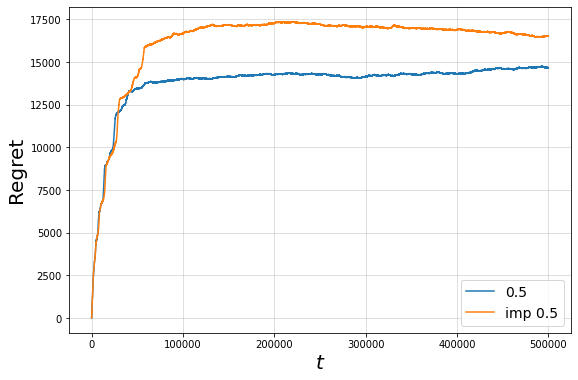

In [ ]:

try:
    regret_reward = np.load('content/scores_improved/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
    
try:
    regret_reward = np.load('content/scores_improved/imp_regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label='imp '+str(alpha))   

plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)

In [ ]:
T = 20000000

#alpha_list = np.linspace(0, 1, num=6)
alpha_list = np.array([0.1,0.9, 1, 0.0])
#means = np.random.random((M, K))


means = np.load("content/movielens_norm_10_40.npy")
M = means.shape[0]
K = means.shape[1]
print(M)
print(K)
n_simu = 10

10
40


In [ ]:
# try to load for a warm restart
try:
    regret_reward = np.load('content/scores_movielens/raw_regret_reward_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
try:  
    raw_regret = np.load('content/scores_movielens/raw_regret_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}
    
try:  
    local_reward = np.load('content/scores_movielens/local_reward_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}
    
try:  
    global_reward = np.load('content/scores_movielens/global_reward_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}
    
try:  
    mixed_reward = np.load('content/scores_movielens/mixed_reward_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [ ]:

try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1

    # also saves the scores if we ran the whole algorithm without interrupting
    np.save('content/scores_movielens/raw_regret_10_40.npy', raw_regret)
    np.save('content/scores_movielens/local_reward_10_40.npy',local_reward)
    np.save('content/scores_movielens/global_reward_10_40.npy',global_reward)
    np.save('content/scores_movielens/mixed_reward_10_40.npy',mixed_reward)
    np.save('content/scores_movielens/regret_reward_10_40.npy', regret_reward)
    del raw_regret, local_reward, global_reward, mixed_reward, regret_reward

    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of trie  s ran: ', len(raw_regret[str(round(alpha,2))]))
    np.save('content/scores_movielens/raw_regret_10_40.npy', raw_regret)
    np.save('content/scores_movielens/local_reward_10_40.npy',local_reward)
    np.save('content/scores_movielens/global_reward_10_40.npy',global_reward)
    np.save('content/scores_movielens/mixed_reward_10_40.npy',mixed_reward)
    np.save('content/scores_movielens/regret_reward_10_40.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward



Simulating P-Fed-UCB, alpha:0.1:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating P-Fed-UCB, alpha:0.1:  10%|█         | 1/10 [1:18:37<11:47:35, 4717.33s/it]

Simulating P-Fed-UCB, alpha:0.1:  20%|██        | 2/10 [2:36:56<10:28:15, 4711.98s/it]

Simulating P-Fed-UCB, alpha:0.1:  30%|███       | 3/10 [3:50:15<8:58:46, 4618.12s/it] 

Simulating P-Fed-UCB, alpha:0.1:  40%|████      | 4/10 [5:02:15<7:32:51, 4528.65s/it]

In [ ]:
mixed_regret_1

NameError: ignored

In [ ]:
try:
    regret_reward = np.load('content/scores_movielens/regret_reward_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)